Our goal is to compare our explanation-based ranking with a personalized ranking produced by matrix factorization.

In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina' 

from lightfm import LightFM
import pandas as pd
import numpy as np
from IPython.display import display
import scipy
from itertools import cycle
import matplotlib as mpl
import matplotlib.pyplot as plt
from glob import glob
import os
import sys

home = os.environ['HOME']
project_dir = '{}/projects/explanations/'.format(home)
sys.path.append(project_dir)
os.chdir(project_dir) 

from explanations.ndcg import ndcg_at_k

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams["font.family"] = 'Merriweather Sans'

hdf5_dir = os.path.join(project_dir, 'hdf5')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# Load explanations for the dataset
path = os.path.join(hdf5_dir, 'ta-bw-nw-a00-sessions.h5')
df_explanations = pd.read_hdf(path)
print('Loaded {:,} explanations'.format(len(df_explanations)))

# Extract columns needed to build interaction matrix.
cols = ['target_item_average_rating', 'target_item_id', 'user_id']
df_ratings = df_explanations[cols].drop_duplicates()
df_ratings.rename(columns={'target_item_average_rating': 'rating', 'target_item_id': 'item_id'}, inplace=True)
print('Found {:,} user-item interactions'.format(len(df_ratings)))

Loaded 405,051 explanations
Found 356,799 user-item interactions


In [3]:
def build_interaction_matrix(df=None):
    """Create user-item interaction matrix.
    
    Args:
        df: DataFrame with columns `user_id`, `item_id` and `rating`
    
    Returns:
        Tuple of (user_ids, item_ids, matrix)
    """
    expected_cols = ['user_id', 'item_id', 'rating']
    common_cols = set(df.columns).intersection(expected_cols)
    assert len(common_cols) == 3

    def _build_interaction_matrix():
        """Build user-item matrix."""
        mat = scipy.sparse.lil_matrix((len(user_ids), len(item_ids)), dtype=np.int32)
        for idx, row in df.iterrows():
            user_idx = user_ids.index(row.user_id)
            item_idx = item_ids.index(row.item_id)
            mat[user_idx, item_idx] = 1.0 if row.rating >= 2.5 else -1.0
        return mat.tocoo()

    user_ids = df_ratings.user_id.unique().tolist()
    item_ids = df_ratings.item_id.unique().tolist()
    matrix = _build_interaction_matrix()
    
    return (user_ids, item_ids, matrix)

user_ids, item_ids, matrix = build_interaction_matrix(df=df_ratings)

In [4]:
model = LightFM(loss='warp')
model.fit(matrix, epochs=30, num_threads=4)

In [5]:
def get_scores():
    def _get_scores():
        for _, row in df_explanations.iterrows():
            user_idx = user_ids.index(row.user_id)
            item_idx = item_ids.index(row.target_item_id)
            score = model.predict(user_idx, np.array([item_idx]))[0]
            yield dict(user_id=row.user_id, item_id=row.target_item_id, score=score)
        
    return pd.DataFrame(_get_scores())

# Extract scores from the model.
df_scores = get_scores()

In [31]:
df_explanations.user_id_target_item_id.nunique(), df_scores.user_id_target_item_id.nunique()

(356799, 356799)

In [27]:
# Merge scores to explanations.
df_explanations['user_id_target_item_id'] = df_explanations.user_id + df_explanations.target_item_id
df_scores['user_id_target_item_id'] = df_scores.user_id + df_scores.item_id

In [39]:
score_map = df_scores[['score','user_id_target_item_id']].set_index('user_id_target_item_id').score.to_dict()

In [40]:
df_explanations['score'] = df_explanations.user_id_target_item_id.map(score_map)
del df_explanations['user_id_target_item_id']
del df_scores['user_id_target_item_id']

In [41]:
print('df_scores: {:,}'.format(len(df_scores)))
print('df_explanations: {:,}'.format(len(df_explanations)))

df_scores: 405,051
df_explanations: 405,051


## Compute NDCGs

In [42]:
df_explanations.rename(columns={'score': 'rank_mf'}, inplace=True)

In [43]:
def compute_ndcgs(df_explanations, include_session_id=True):
    """Computes NDCG for sessions in a explanation DataFrame
    
    Args:
        df_explanations (pd.DataFrame): Explanation DataFrame
        include_session_id (bool): Whether or not to include session_ids in the output DataFrame
        
    Returns:
    
    """
    rank_cols = ['rank_related_items_sims_np', 'rank_mf', 'rank_strength', 'rank_target_item_average_rating']
    
    def _compute(df, method=2, session_id=None):
        df_len = len(df)
        for col in rank_cols:
            df_sorted = df.sort_values(col)
            average_ratings = df_sorted.target_item_average_rating.values
            for idx in range(df_len):
                k = idx + 1
                yield dict(k=k, col=col, session_id=session_id, ndcg=ndcg_at_k(average_ratings, k=k, method=method))

    # Columns used in computing NDCGs
    ndcg_cols = rank_cols + ['session_id', 'target_item_average_rating']
    def _run():
        for idx, (session_id, df) in enumerate(df_explanations.groupby('session_id', sort=False)):
            yield from _compute(df=df, session_id=session_id)
    return pd.DataFrame.from_dict(_run())

In [44]:
df_ndcgs = compute_ndcgs(df_explanations, include_session_id=True)

In [45]:
len(df_explanations)

405051

In [46]:
exclude_cols = ['rank_strength_comp', 'rank_target_item_average_rating']
exclude_cols = ['rank_target_item_average_rating']
df_ndcgs_summary = df_ndcgs.query('col != @exclude_cols').groupby(['col', 'k']).ndcg.mean()
df_ndcgs_summary = df_ndcgs_summary.reset_index()

In [47]:
cols = df_ndcgs_summary.col.unique()
cols

array(['rank_mf', 'rank_related_items_sims_np', 'rank_strength'], dtype=object)

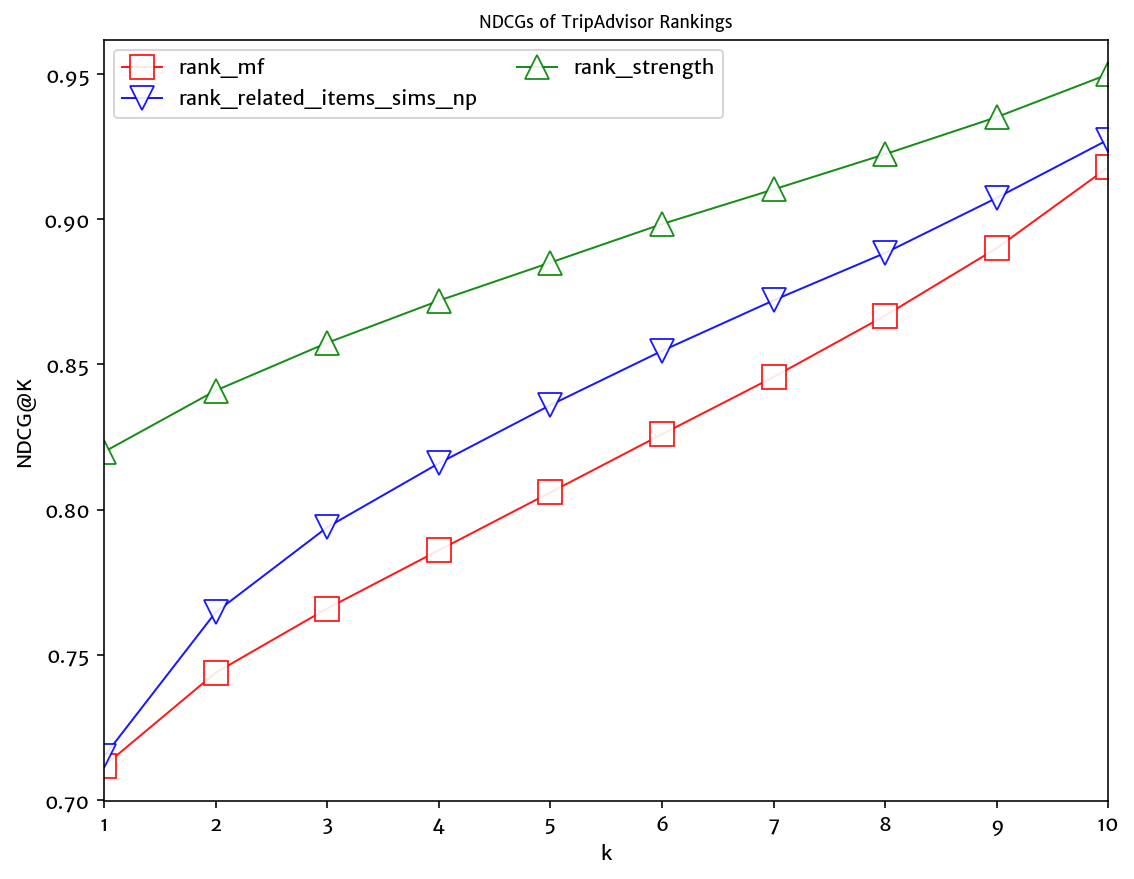

In [50]:
def plot_ndcgs_new(dataset, markersize=12, figsize=(9, 7), title=None, exclude_alphas=None, ylim=None, ylabel=None,
                   exclude_weights=None, ax=None, title_fontsize='small'):
    markers = cycle(['s', 'v', '^', 'o', 'D', '<', '>', 'p', '*', '+', 'd', '1', 
                 '2', '3', '4', '8'])
    colors = cycle(['r', 'b', 'g', 'y', 'c', 'm', 'k'])
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    rank_related_items_sims_np = False

    for col in cols:
        df = df_ndcgs_summary
        label = col
        c = next(colors)

        df.query('col == @col').set_index('k').rename(columns={'ndcg': label}).plot(
            kind='line', 
            ax=ax, 
            marker=next(markers), 
            markersize=markersize, 
            linewidth=1, 
            alpha=0.9, 
            label=label, 
            color=c, 
            linestyle='-', 
            markerfacecolor='w', 
            markeredgewidth=0.9,
            legend=False
        )
        

    ax.legend(scatterpoints=2, ncol=2, loc='best')
    ax.set_title(title, fontsize=title_fontsize)
    if ylabel:
        ax.set_ylabel(ylabel)
    if ylim:
        ax.set_ylim(ylim)
        
    filename = title.lower().replace(' ', '-')
        

plot_ndcgs_new(dataset='ta', title='NDCGs of TripAdvisor Rankings', ylabel='NDCG@K')

In [ ]:
# sns.set_context('poster')
# sns.set_style('white')


plot_ndcgs_new(dataset='ta', title='NDCGs of TripAdvisor Rankings', ylabel='NDCG@K')